In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector
import time

In [3]:
class PID:
    def __init__(self, K_p=0.0, K_i=0.0, K_d=0.0, integral_limit=None):
        """Constructor
        Args:
            K_p (float): The proportional gain
            K_i (float): The integral gain
            K_d (float): The derivative gain
            integral_limit (float, optional): The integral limit
        """
        self.K_p = K_p
        self.K_i = K_i
        self.K_d = K_d
        self.integral_limit = integral_limit

        self.reset()

    def reset(self):
        """Reset the PID controller"""
        self.last_error = 0.0
        self.integral = 0.0
        self.last_time = time.time()

    def update(self, error, error_derivative=None):
        """Update the PID controller
        Args:
            error (float): The current error
        """
        current_time = time.time()
        dt = current_time - self.last_time

        if dt == 0:
            return 0.0

        self.last_time = current_time
        print("last error: ", self.last_error, "error: ", error)
        self.integral = self._get_integral(error, dt)
        if error_derivative is None:
            derivative = self._get_derivative(error, dt)
        else:
            derivative = error_derivative

        # TODO: Calculate the PID output
        output = self.K_p*(self.last_error)+self.K_i*(self.integral)+self.K_d*derivative

        self.last_error = error

        return output

    def _get_integral(self, error, dt):
        """Calculate the integral term
        Args:
            error (float): The current error
            dt (float): The time delta
        Returns:
            float: The integral term
        """

        # TODO: Calculate and return the integral term
        self.integral+= error * dt
        if self.integral is not None:
            self.integral = np.clip(self.integral, -1*self.integral_limit, self.integral_limit)
        return self.integral

    def _get_derivative(self, error, dt):
        """Calculate the derivative term
        Args:
            error (float): The current error
            dt (float): The time delta
        Returns:
            float: The derivative term
        """

        # TODO: Calculate and return the derivative term
        derivative = (error-self.last_error)/dt
        self.error = error
        return derivative


(960, 540)
distance: (136, -224)
last error:  0.0 error:  136
0.0
last error:  0.0 error:  -224
0.0


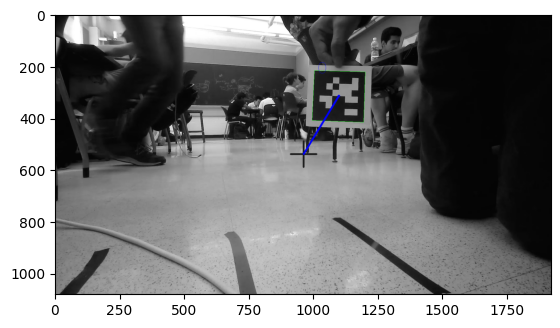

(960, 540)
distance: (164, -117)
last error:  136 error:  164
4080.0
last error:  -224 error:  -117
-6720.0


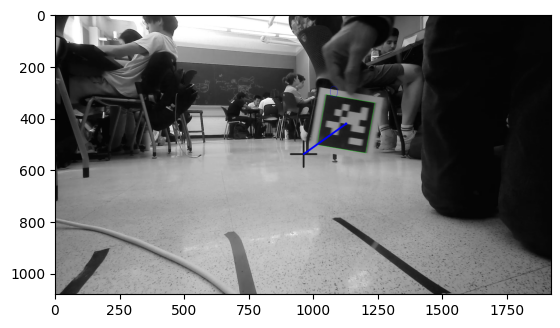

(960, 540)
distance: (-120, -296)
last error:  164 error:  -120
4920.0
last error:  -117 error:  -296
-3510.0


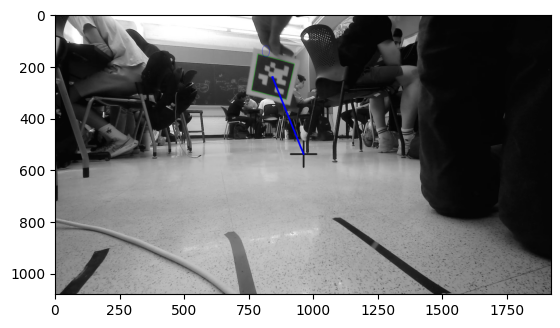

(960, 540)
distance: (-120, -296)
last error:  -120 error:  -120
-3600.0
last error:  -296 error:  -296
-8880.0


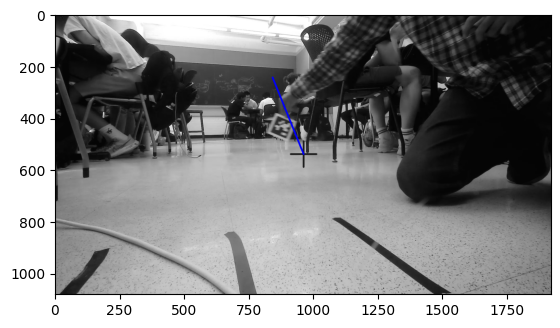

(960, 540)
distance: (-120, -296)
last error:  -120 error:  -120
-3600.0
last error:  -296 error:  -296
-8880.0


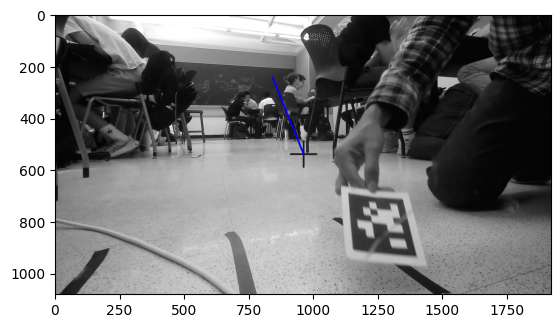

(960, 540)
distance: (265, 348)
last error:  -120 error:  265
-3600.0
last error:  -296 error:  348
-8880.0


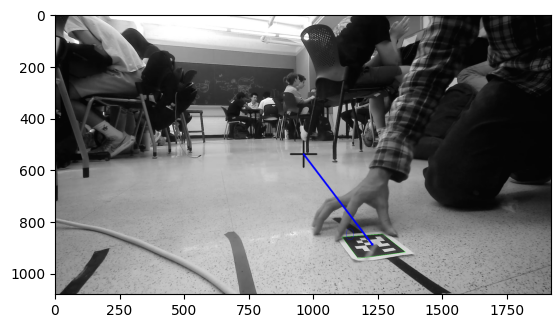

(960, 540)
distance: (265, 348)
last error:  265 error:  265
7950.0
last error:  348 error:  348
10440.0


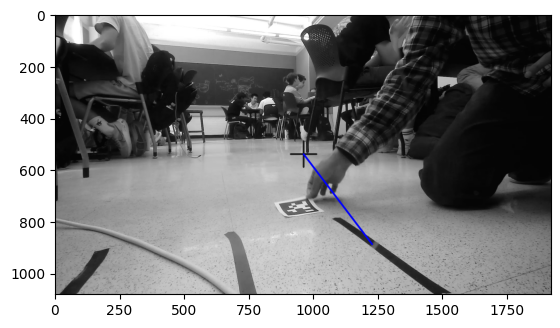

(960, 540)
distance: (-370, -16)
last error:  265 error:  -370
7950.0
last error:  348 error:  -16
10440.0


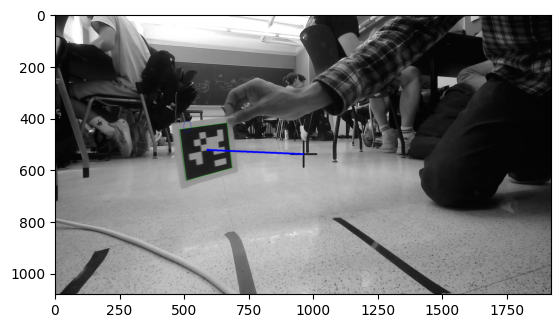

(960, 540)
distance: (214, -170)
last error:  -370 error:  214
-11100.0
last error:  -16 error:  -170
-480.0


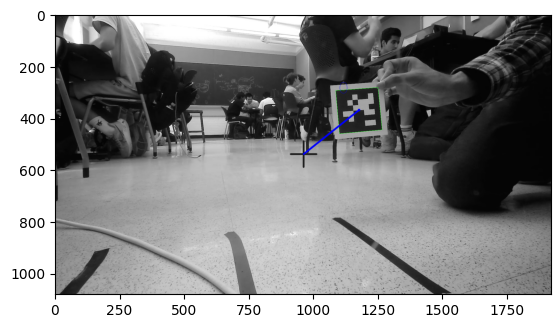

In [14]:
cap = cv2.VideoCapture('AprilTagTest.mkv')
success = cap.grab()
frames = []
slopes = []
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.4,
                       debug=0)
cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))
camera_params = (cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )
i=0
pid_x = PID(30, 0, 0,100)
pid_y = PID(30, 0, 0,100)

while success:
    if i % 100  == 0:
        
        _, frame = cap.retrieve()
        height, width, depth = frame.shape
        center = (int(width/2),int(height/2))
        print(center)
        cv2.line(frame, (int(width/2), center[1]-50), (int(width/2), center[1]+50), (255, 0, 0), 5)
        cv2.line(frame, (center[0]-50,int(height/2)), (center[0]+50, int(height/2)), (255, 0, 0), 5)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        tags = at_detector.detect(frame, True, camera_params, 0.1)
        color_img = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        for tag in tags:
            for idx in range(len(tag.corners)):
                #drawing the lines and write text
                cv2.line(color_img, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))
                cv2.putText(color_img, str(tag.tag_id),
                org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2,
                color=(0, 0, 255))
            (cX, cY) = (int(tag.center[0]), int(tag.center[1]))
            cv2.circle(color_img, (cX, cY), 5, (0, 0, 255), -1)
            dist = (cX-center[0],cY-center[1])
            print(f"distance: {dist[0],dist[1]}")
            cv2.line(color_img,center,(int(cX),int(cY)),(0, 0, 255),5)

        print(pid_x.update(dist[0]))
        print(pid_y.update(dist[1]))

        plt.imshow(color_img)
        plt.pause(0.01)  # Pause for a short time to show the figure
        plt.clf()
    i+=1
    success = cap.grab()

# Release the video capture
cap.release()

# Close the plot window
plt.close()